In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model


In [3]:
filename = "AI_Engineer_Dataset_Task_1.xlsx"

In [4]:
data = pd.read_excel(filename)
data.head()

,AcademicYear,SemesterName,ParticipantID,DegreeLevel,Gender,Nationality,StudentProgram,CourseCode,CourseName,QuestionText,QuestionType,ParticipantResponse
0,2021,Fall 2021 - 2022,7040336900,Bachelor,Female,Palestine,Bachelor of Business Administration,ACC 100,Principles of Accounting,CLO : Evaluate financial and managerial accoun...,Rating,Disagree
1,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The coursework and assignments are challenging,Rating,Strongly Disagree
2,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The course is relevant to my program of study,Rating,Strongly Disagree
3,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,Course learning materials are available on the...,Rating,Strongly Disagree
4,2021,Fall 2021 - 2022,6707335167,Bachelor,Male,United Arab Emirates,Bachelor of Business Administration,ACC 100,Principles of Accounting,The faculty uses additional resources (other t...,Rating,Strongly Disagree


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180969 entries, 0 to 180968
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   AcademicYear         180969 non-null  int64 
 1   SemesterName         180969 non-null  object
 2   ParticipantID        180969 non-null  int64 
 3   DegreeLevel          180969 non-null  object
 4   Gender               180969 non-null  object
 5   Nationality          180969 non-null  object
 6   StudentProgram       180969 non-null  object
 7   CourseCode           180969 non-null  object
 8   CourseName           180969 non-null  object
 9   QuestionText         180969 non-null  object
 10  QuestionType         180969 non-null  object
 11  ParticipantResponse  168802 non-null  object
dtypes: int64(2), object(10)
memory usage: 16.6+ MB


In [6]:
data.describe()

,AcademicYear,ParticipantID
count,180969.000000,1.809690e+05
mean,2021.528864,6.603992e+09
std,0.500163,5.140711e+08
min,2021.000000,4.727001e+09
25%,2021.000000,6.373667e+09
50%,2022.000000,6.707001e+09
75%,2022.000000,7.040668e+09
max,2023.000000,7.427334e+09


In [ ]:
list(data.columns)

### Data Visualization


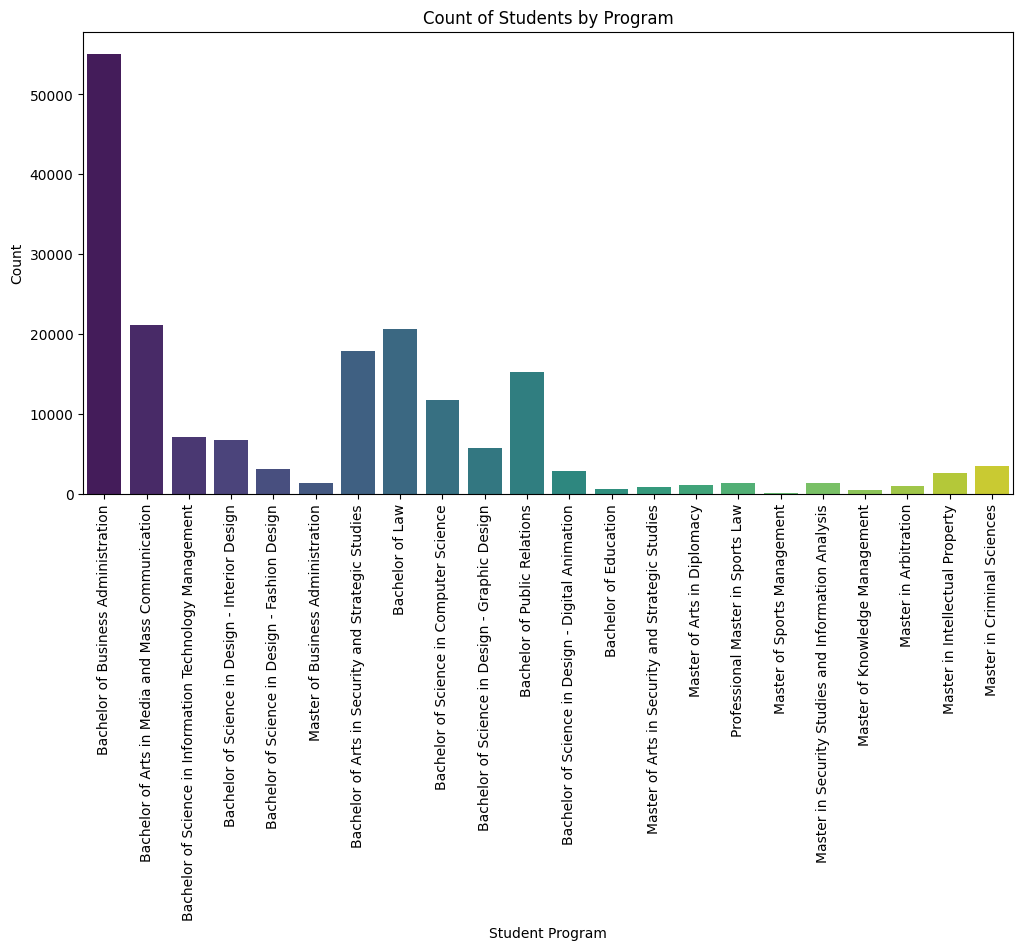

In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='StudentProgram', palette='viridis')
plt.xticks(rotation=90)
plt.title('Count of Students by Program')
plt.xlabel('Student Program')
plt.ylabel('Count')
plt.show()

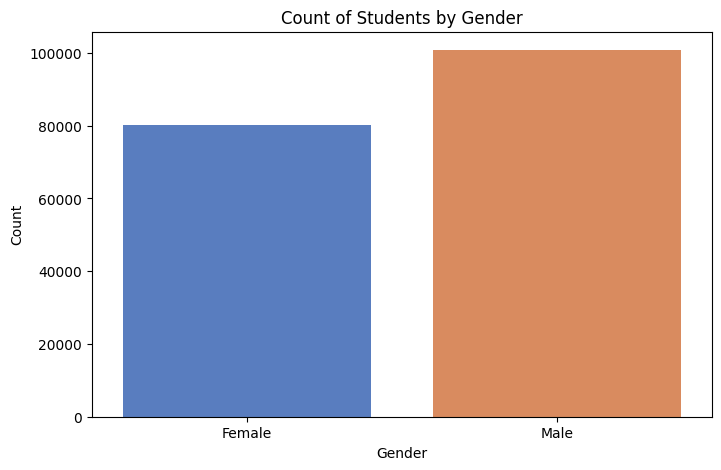

In [8]:
# Countplot of Gender
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Gender', palette='muted')
plt.title('Count of Students by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


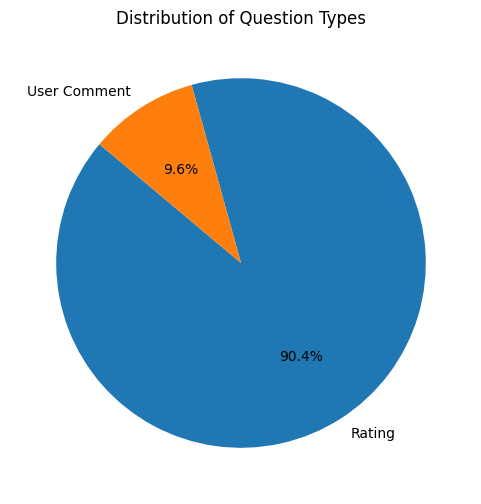

In [9]:
# Pie chart for QuestionType distribution
question_type_counts = data['QuestionType'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(question_type_counts, labels=question_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Question Types')
plt.show()

D:\Development\Assignment\Emirates_Uni\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


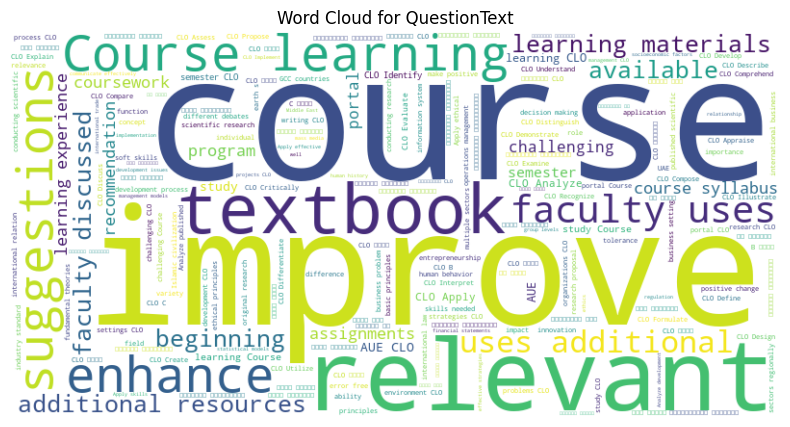

In [10]:

# Word cloud for QuestionText
from wordcloud import WordCloud

# Concatenate all QuestionText
all_text = ' '.join(data['QuestionText'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for QuestionText')
plt.axis('off')
plt.show()

# Sentiment Analysis

In [11]:
def classify_sentiment(text):
    analysis = TextBlob(text)
    sentiment_polarity = analysis.sentiment.polarity

    if sentiment_polarity > 0:
        return 'Positive'
    elif sentiment_polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

__As given in the question. We need to analyze feedback comments and perform sentiment analysis on it.
Hence we will need to filter out the `User Comment` data and also drop null values.__

__Lets take the sample data from the whole data on which we need to perform the sentiment Analysis.__

In [12]:
sample_data = data[data['QuestionType']=='User Comment'].dropna()

In [13]:
sample_data['sentiment'] = sample_data['ParticipantResponse'].apply(classify_sentiment)

In [14]:
sample_data['sentiment']

32         Neutral
93         Neutral
129       Positive
182        Neutral
202       Positive
            ...   
180710     Neutral
180740     Neutral
180939     Neutral
180948     Neutral
180961     Neutral
Name: sentiment, Length: 5177, dtype: object

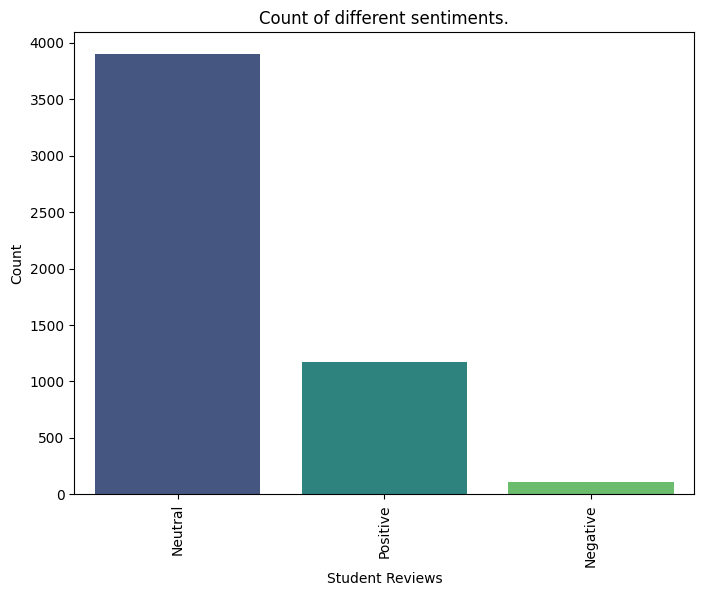

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(data=sample_data, x='sentiment', palette='viridis')
plt.title('Count of different sentiments.')
plt.xlabel('Student Reviews')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.show()

# Topic Modelling

In [16]:

# Preprocess the "ParticipantResponse" column
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters, numbers, and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text using NLTK (you may need to download nltk data if not already done)
    tokens = nltk.word_tokenize(text)

    # Remove stopwords using NLTK's English stopwords list
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stopwords]

    # Join tokens back into a string
    cleaned_text = ' '.join(tokens)

    return cleaned_text




In [17]:
# Apply preprocessing to the "ParticipantResponse" column
sample_data['ParticipantResponse'] = sample_data['ParticipantResponse'].apply(preprocess_text)



In [18]:
# Create a Document-Term Matrix (DTM) using Count Vectorization
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
dtm = vectorizer.fit_transform(sample_data['ParticipantResponse'])



In [19]:
# Apply LDA
num_topics = 5  #  can adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)



LatentDirichletAllocation(n_components=5, random_state=42)

In [20]:
# Visualize the topics
def visualize_topics(lda_model, vectorizer, top_n_words=10):
    for topic_idx, topic in enumerate(lda_model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_n_words - 1:-1]])

visualize_topics(lda_model, vectorizer)

Topic #1:
['course', 'students', 'really', 'dr', 'recommendations', 'understand', 'courses', 'helpful', 'learned', 'lot']
Topic #2:
['dr', 'best', 'course', 'perfect', 'clear', 'na', 'class', 'courses', 'university', 'excellent']
Topic #3:
['good', 'amazing', 'best', 'dr', 'doctor', 'comment', 'instructor', 'course', 'way', 'students']
Topic #4:
['great', 'thank', 'course', 'dr', 'student', 'class', 'like', 'nice', 'work', 'learn']
Topic #5:
['thanks', 'course', 'doctor', 'information', 'interesting', 'really', 'nil', 'semester', 'non', 'provided']


In [21]:

# Apply LDA
num_topics = 5  # You can adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Visualize topics using pyLDAvis.lda_model
vis = pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer)

# Display the visualization
pyLDAvis.display(vis)
